# XGBoost (iris) - Classification
[ch5-advanced-xgboost-unveiled.ipynb](https://github.com/kyopark2014/ML-Algorithms/blob/main/xgboost/src/ch5-advanced-xgboost-unveiled.ipynb)

In [37]:
!pip install xgboost

You should consider upgrading via the '/Users/ksdyb/.pyenv/versions/3.9.12/bin/python3.9 -m pip install --upgrade pip' command.


In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
import numpy as np
import pandas as pd
import time

In [40]:
import xgboost as xgb
xgb.set_config(verbosity=0)

In [41]:
from sklearn import datasets
iris = datasets.load_iris()

In [42]:
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])

In [43]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Shuffle

In [44]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=2)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
6,4.6,3.4,1.4,0.3,0.0
3,4.6,3.1,1.5,0.2,0.0
113,5.7,2.5,5.0,2.0,2.0
12,4.8,3.0,1.4,0.1,0.0
24,4.8,3.4,1.9,0.2,0.0


In [45]:
df['target'].value_counts()

0.0    50
2.0    50
1.0    50
Name: target, dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 6 to 15
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 7.0 KB


In [47]:
df.isna().sum().sum()

0

## Define Feature and Target

In [48]:
X = iris['data']
y = iris['target']

## Classification Model Selection

In [49]:
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    # scores = cross_val_score(model, X, y, scoring='recall', cv=kfold)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('Accuracy:', np.round(scores, 2))
    print('Avg. Accuracy: %0.2f' % (scores.mean()))

In [50]:
cross_validation(XGBClassifier(booster='gbtree'))  # default

Cross Validation:
Elased time: 0.58s
Accuracy: [0.97 0.97 0.93 0.93 1.  ]
Avg. Accuracy: 0.96


In [51]:
cross_validation(XGBClassifier(booster='gblinear'))

Cross Validation:
Elased time: 0.21s
Accuracy: [1.   1.   0.93 0.9  1.  ]
Avg. Accuracy: 0.97


In [52]:
cross_validation(XGBClassifier(booster='dart', one_drop=1))

Cross Validation:
Elased time: 5.84s
Accuracy: [0.97 0.97 0.93 0.93 1.  ]
Avg. Accuracy: 0.96


In [53]:
from sklearn.ensemble import RandomForestClassifier

cross_validation(RandomForestClassifier())

Cross Validation:
Elased time: 0.24s
Accuracy: [0.97 0.97 0.93 0.93 1.  ]
Avg. Accuracy: 0.96


## HPO

### Default

In [54]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Utility function to estimate accuracy scores
def model_estimation(model):    
    start = time.time()
    y_pred = model.predict(X_test)

    from sklearn.metrics import confusion_matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    from sklearn.metrics import classification_report
    print('\nClassification Report:')
    print(classification_report(y_true=y_test, y_pred = y_pred))

    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('Accuracy Score: %0.2f' % (accuracy_score(y_test,y_pred)))
    print('Precision Score: %0.2f' % (precision_score(y_test,y_pred,average='weighted')))
    print('Recall Score: %0.2f' % (recall_score(y_test,y_pred,average='weighted')))
    print('F1 Score: %0.2f' % (f1_score(y_test,y_pred,average='weighted')))
    print('Elapsed time: %0.2fs' % (time.time()-start)) 
    
    return accuracy_score(y_test,y_pred)

In [55]:
# default model
model = XGBClassifier(booster='gbtree', objective='multi:softmax', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

best_score = model_estimation(model)
best_model = model

print('\nbest_score: %0.3f' % (best_score))


Confusion Matrix:
[[16  0  0]
 [ 0 10  1]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        11

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Accuracy Score: 0.97
Precision Score: 0.98
Recall Score: 0.97
F1 Score: 0.97
Elapsed time: 0.00s

best_score: 0.974


In [58]:
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

## HPO: Randomized Search

In [59]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs=20): 
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    rand_clf = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=runs, n_jobs=-1, random_state=2, scoring='accuracy')
    
    rand_clf.fit(X_train, y_train)    
    
    best_model = rand_clf.best_estimator_    
    
    print("best parameter:", rand_clf.best_params_)    
    print("best score: {:.3f}".format(rand_clf.best_score_))

    # print("rand_clf.cv_results_: ", rand_clf.cv_results_)
    report(rand_clf.cv_results_)
    
    return best_model

In [60]:
import time
start = time.time()

randomized_model = randomized_search(
    params={
        'n_estimators':[50, 100, 200],
        'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8],
        'max_depth':[1, 2, 3, 5, 6, 8],
        'gamma':[0, 0.01, 0.1, 0.5, 0.7, 1, 2],
        'min_child_weight':[5, 10, 15, 20, 30],
        'subsample':[0.5, 0.7, 0.8, 0.9, 1],
        'colsample_bytree':[0.2, 0.5, 0.7, 0.8, 0.9, 1],  
        }, 
    runs=20)

print('\nElapsed time: %0.2fs' % (time.time()-start))

best parameter: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score: 0.946
Model with rank: 1
Mean validation score: 0.946 (std: 0.052)
Parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.5, 'colsample_bytree': 0.8}

Model with rank: 2
Mean validation score: 0.937 (std: 0.046)
Parameters: {'subsample': 1, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}

Model with rank: 2
Mean validation score: 0.937 (std: 0.046)
Parameters: {'subsample': 0.9, 'n_estimators': 50, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.7, 'colsample_bytree': 1}

Model with rank: 2
Mean validation score: 0.937 (std: 0.046)
Parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.8, 'gamma': 0.01, '

In [ ]:
best_model.get_params()

## HPO: Bayesian Optimization 

In [61]:
from bayes_opt import BayesianOptimization

def xgbc_cv(n_estimators, learning_rate, max_depth, gamma, min_child_weight, subsample, colsample_bytree, ):
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        n_estimators=int(n_estimators),
                        learning_rate=learning_rate,
                        max_depth=int(max_depth),
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

    xgb.fit(X_train, y_train)    

    y_pred = xgb.predict(X_test)

    score = accuracy_score(y_pred, y_test)

    print('score=', score)

    return score

hyperparameter_space = {
    'n_estimators': (50, 800),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 8),
    'gamma' : (0.01, 1),
    'min_child_weight': (1, 20),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.1, 1)
}

optimizer = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=2, verbose=0)

#gp_params = {"alpha": 1e-10}
#optimizer.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)    

#optimizer.maximize(init_points=2, n_iter=10)
optimizer.maximize(init_points=3, n_iter=5, acq='ei')


optimizer.max

score= 0.9473684210526315
score= 0.9473684210526315
score= 0.8947368421052632
score= 0.9473684210526315
score= 0.9736842105263158
score= 0.9736842105263158
score= 0.9210526315789473
score= 0.9736842105263158


{'target': 0.9736842105263158,
 'params': {'colsample_bytree': 0.7695292779901088,
  'gamma': 0.9756074715693757,
  'learning_rate': 0.38899979015098973,
  'max_depth': 6.024217507534088,
  'min_child_weight': 7.585235337677671,
  'n_estimators': 171.7050829958862,
  'subsample': 0.8700764934314554}}

In [62]:
best_params = optimizer.max['params']

In [63]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        n_estimators=int(best_params['n_estimators']), 
                        learning_rate=best_params['learning_rate'], 
                        max_depth=int(best_params['max_depth']), 
                        gamma=best_params['gamma'], 
                        min_child_weight=int(best_params['min_child_weight']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

y_pred = model.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('score=', score)     

if(score > best_score): 
    best_score = score
    best_model = model
    
    best_score = model_estimation(model)
    print('\nbest_score: %0.3f' % (best_score))

score= 0.9473684210526315


## Evaluation

In [64]:
cross_validation(best_model)   
model_estimation(best_model)       

Cross Validation:
Elased time: 0.60s
Accuracy: [0.97 0.97 0.93 0.93 1.  ]
Avg. Accuracy: 0.96

Confusion Matrix:
[[16  0  0]
 [ 0 10  1]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        11

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Accuracy Score: 0.97
Precision Score: 0.98
Recall Score: 0.97
F1 Score: 0.97
Elapsed time: 0.00s


0.9736842105263158

## Feature Importances

Feature Importances:
[0.02359601 0.0325651  0.64519393 0.29864496]
You should consider upgrading via the '/Users/ksdyb/.pyenv/versions/3.9.12/bin/python3.9 -m pip install --upgrade pip' command.


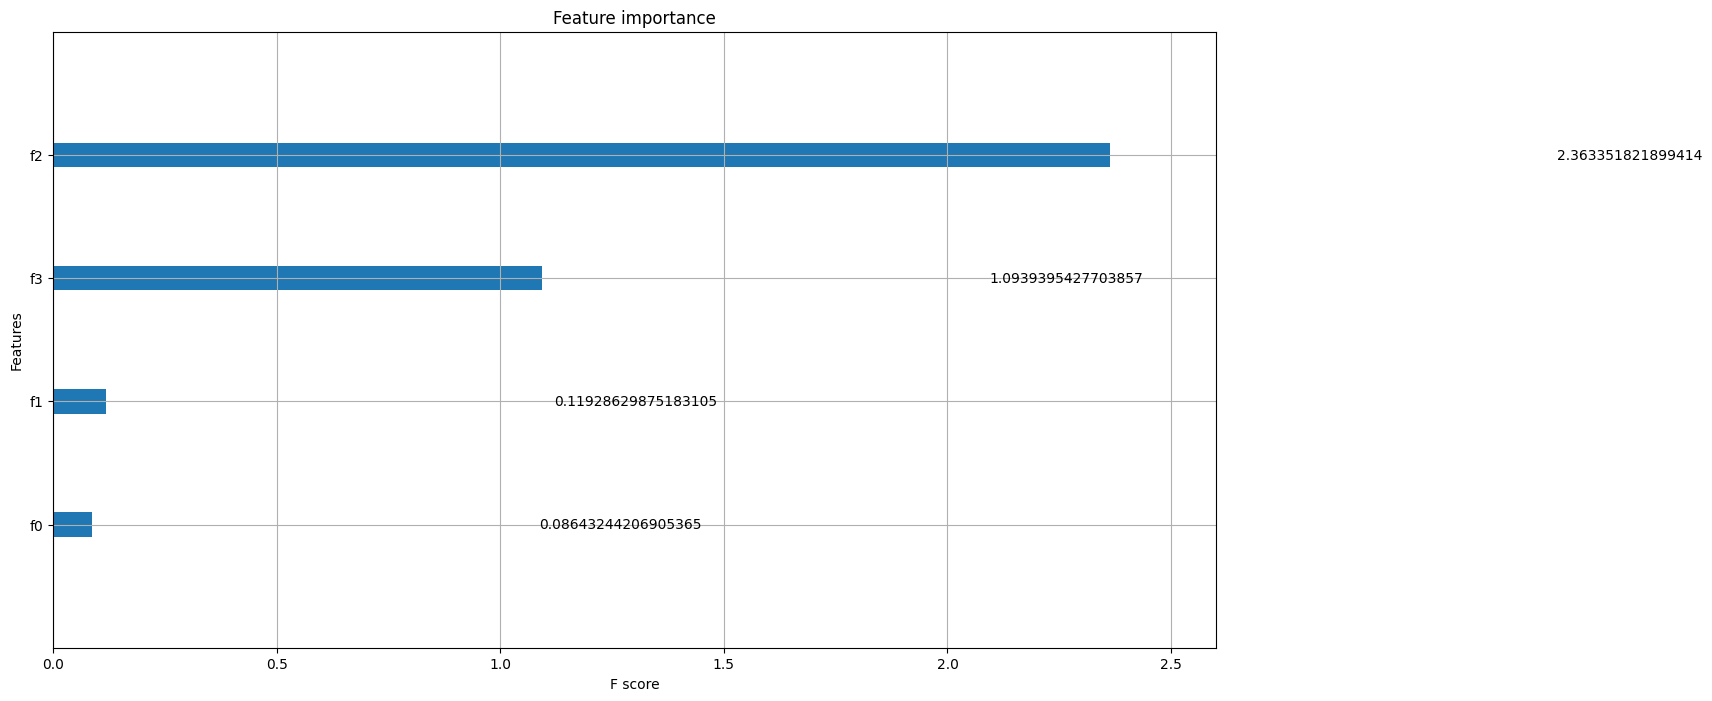

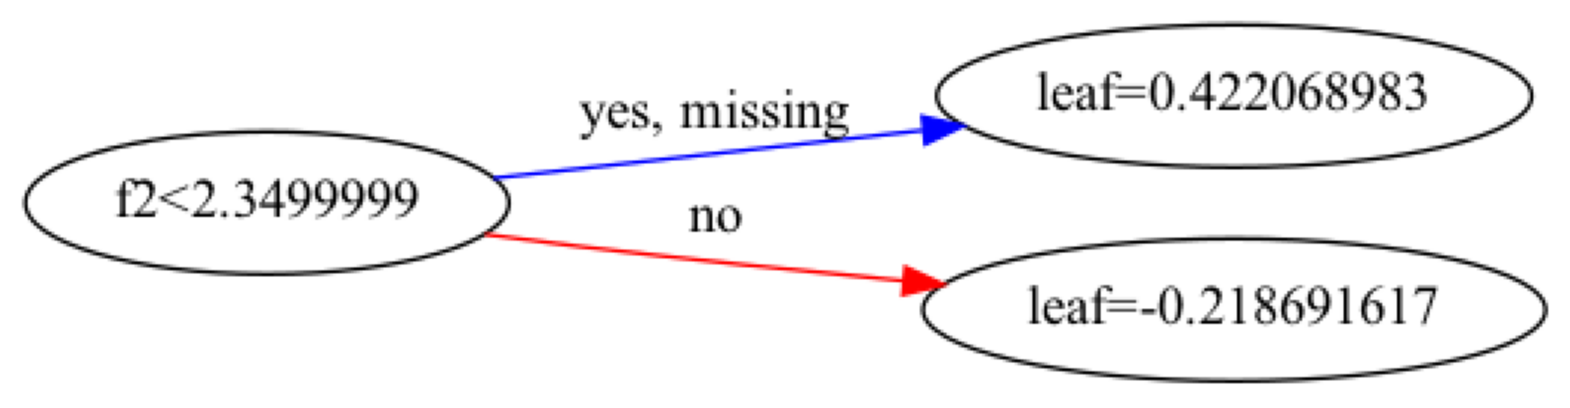

In [65]:
print('Feature Importances:')
print(best_model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
best_model.get_booster().feature_names = feature_data.feature_names
best_model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(best_model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(best_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()